In [1]:
# Load packages
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import numpy as np
import numpy.matlib as matlib
import glob
import calendar
import regionmask

In [2]:
# Growing season definition
def is_GS(month):
    return (month >= 5) & (month <= 10)

In [3]:
## Calculations on observational data 
fname = '/glade/work/tanderson/GPCC/gpcc_05_v2020.nc'

#Load GPCC obs
dset_obs = xr.open_mfdataset(fname)
dset_obs = dset_obs.sel(lat=slice(18,11), lon=slice(-93,-83), time=slice('1920-01-01','2019-12-01')) # slice data to lat and lons of interest

dset_obs.attrs['units'] = 'mm/month'

dset_obs_year = dset_obs['time.year']
dset_obs_month = dset_obs['time.month']

# Make a regional mask
land = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(dset_obs)

# Precip Masked
obsLand = dset_obs.where(land==0).load()
#obsLand.precip[1].plot()

 # Get annual precip total 
annObs = obsLand.groupby('time.year').sum('time', skipna=False, keep_attrs=True) 
    
# Get annual GS total
GSObs = obsLand.sel(time=is_GS(obsLand['time.month']))
GSObs = GSObs.groupby('time.year').sum('time', skipna=False, keep_attrs=True) 
    
# Calculate % of annual rainfall in GS
GSpercObs = np.divide(GSObs,annObs)*100
    
# Get average annual % of rainfall
avgGSpercObs = GSpercObs.mean('year', keep_attrs=True)
    
# Get mean growing season precip
meanGSObs = GSObs.mean('year', keep_attrs=True)
       
# Get annual anomalies of % of normal growing season rainfall
GSanomPObs = np.divide(GSObs,meanGSObs)*100-100
GS5yrAllObs = GSanomPObs.rolling(year=5).mean()
  
# Mask where annual growing season rainfall <75% of annual
GSanomPObs = GSanomPObs.where(avgGSpercObs>75)

#Take regional mean
regTS_GSObs = GSanomPObs.mean(['lat','lon'])
  
# Get 5 year moving mean for region
reg5mov_GSObs = regTS_GSObs.rolling(year=5).mean()


In [16]:
# Load the OLEns regional 5-year time series
memTS_GS_5yr = np.loadtxt('/glade/work/tanderson/DC_Drought/OutputAnalysisData/v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew-regionalGS-TS-5yr.csv', delimiter=',')
print(memTS_GS_5yr.shape) # years x ensemble members

(100, 1000)


In [11]:
# Find events lower than 2015-2019 obs drought
dry = memTS_GS_5yr <= reg5mov_GSObs.precip.values[-1]

# Get indices of those events (row = year, column = ensemble member)
inds_dry = np.transpose((dry).nonzero())

(1360, 2)


In [17]:
# Get anomaly correlations to determine which ensemble members to plot

# Get number of drought possibilities
n_ens_mems = len(inds_dry)

# Set empty array (lats x lons, number ensemble members)
GS_unravel_OLE = np.empty((len(GSanomPObs.lat)*len(GSanomPObs.lon), n_ens_mems)) 
ens_name = np.empty((n_ens_mems))

for i in range(0, len(inds_dry)):
    plt_file = '/glade/scratch/tanderson/obsLEAnalysis/GStotals_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/GStotal_member%04d.nc' % (inds_dry[i][1] + 1) # add one to file since they start at 0001
    dset_plt = xr.open_dataset(plt_file)

    # Get mean growing season precip
    meanGS = dset_plt.mean('year', keep_attrs=True)

    # Get annual anomalies of % of normal growing season rainfall
    GSanomP = np.divide(dset_plt,meanGS)*100-100
    
    # 5year rolling mean
    GS5yrAll = GSanomP.rolling(year=5).mean()
    
    # Values for year that is at least as dry as 2015-2019 drought
    get_vals = GS5yrAll.sel(year=GS5yrAll.year.values[[inds_dry[i][0]]]).precip.values.flatten()
    GS_unravel_OLE[:,i] = get_vals
    
    # Need file name for plot
    ens_name[i] = inds_dry[i][1] + 1



In [18]:
# Do correlation

# Put obs and all dry ensemble member values in one matrix
mat = pd.concat((pd.DataFrame(GS5yrAllObs.sel(year=2019).precip.values.flatten()), pd.DataFrame(GS_unravel_OLE)),axis=1)
print(mat.shape)

# Correlation matrix
mat_corr = mat.corr()
print(mat_corr.shape)

# Remove obs correlation with itself
mat_corr_vals = mat_corr.iloc[1:,0]
print(mat_corr_vals)

# Sort correlations
mat_sort= mat_corr_vals.sort_values(ascending=False,ignore_index=True) # keep original index
print(mat_sort)

(280, 1361)
(1361, 1361)
0       0.121389
1      -0.160496
2       0.057949
3      -0.072537
4       0.415418
          ...   
1355   -0.053839
1356    0.288646
1357    0.355626
1358   -0.115926
1359   -0.130366
Name: 0, Length: 1360, dtype: float64
0       0.857174
1       0.809795
2       0.781109
3       0.763270
4       0.761322
          ...   
1355   -0.387565
1356   -0.397405
1357   -0.420490
1358   -0.437958
1359   -0.473005
Name: 0, Length: 1360, dtype: float64


743    0.857174
Name: 0, dtype: float64
-12.73641711196914
/glade/scratch/tanderson/obsLEAnalysis/GStotals_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/GStotal_member0260.nc
743
233    0.322848
Name: 0, dtype: float64
-12.38548162422326
/glade/scratch/tanderson/obsLEAnalysis/GStotals_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/GStotal_member0059.nc
233
1052    0.017929
Name: 0, dtype: float64
-11.536058434926513
/glade/scratch/tanderson/obsLEAnalysis/GStotals_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/GStotal_member0598.nc
1052
851   -0.473005
Name: 0, dtype: float64
-13.198140219604198
/glade/scratch/tanderson/obsLEAnalysis/GStotals_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/GStotal_member0894.nc
851


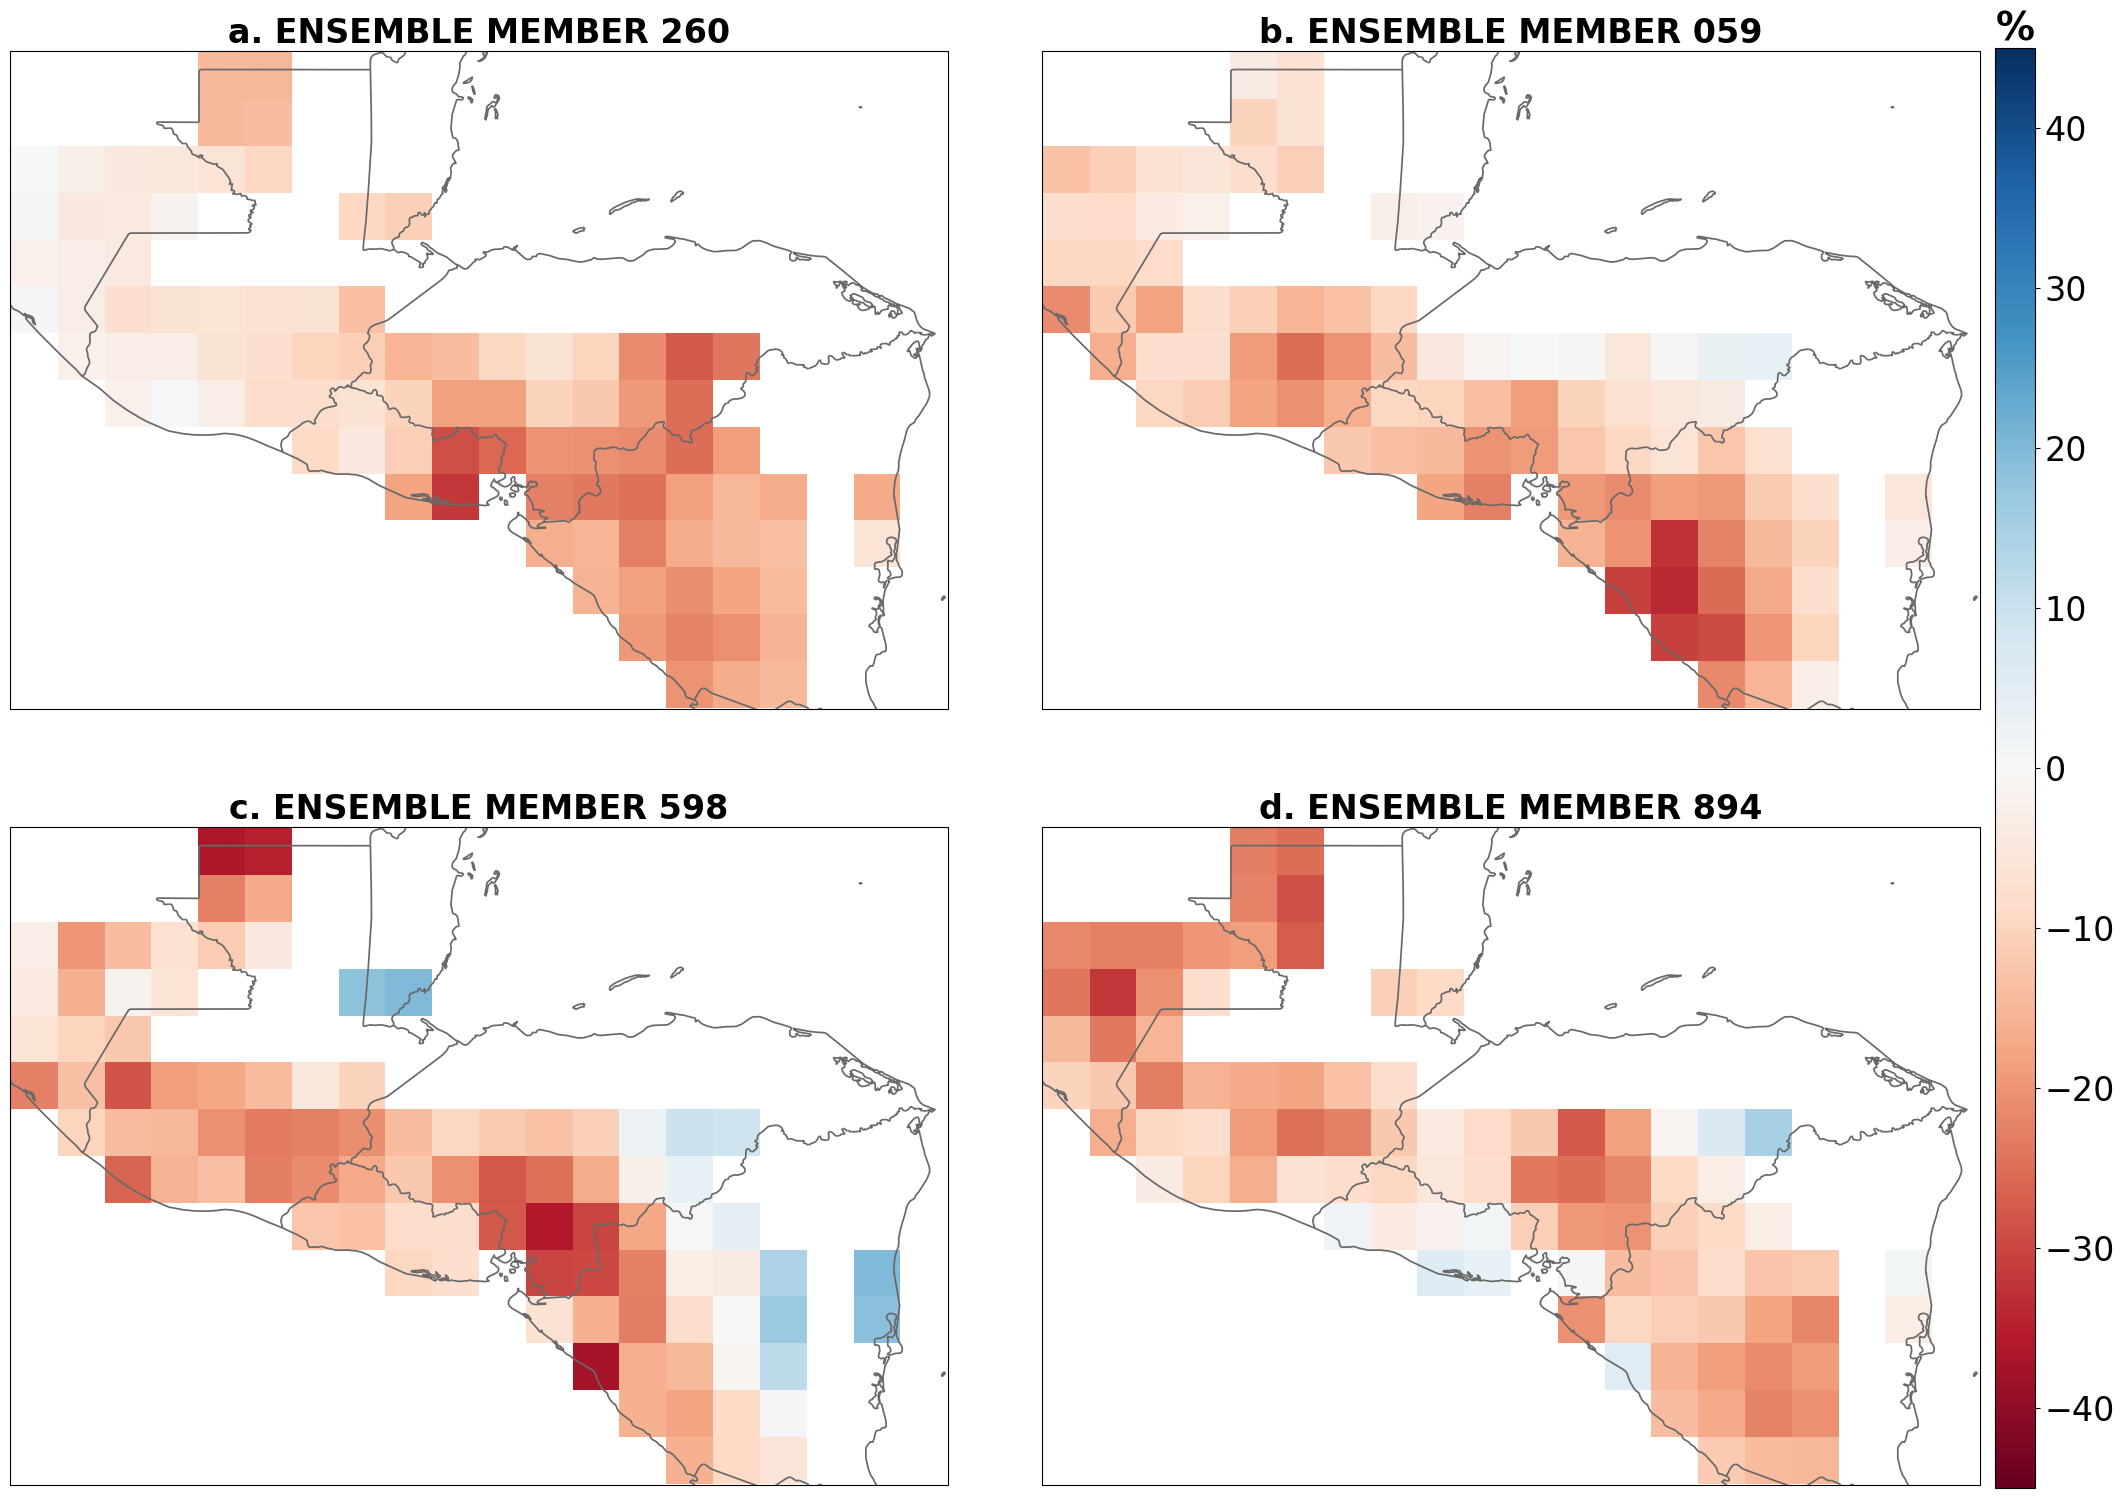

In [24]:
# Plot multiple drought examples

# Choose quantile values of correlations to plot
threshold = [1, 0.75, 0.25, 0.0]

# Plot labels
figlet = ['a','b','c','d']

fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(20,20),subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
axs = axs.flatten()
figsize=(25, 20)

# Set standard range, so that all plots are the same
vmin = -45
vmax=45
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

for i in range(0, len(threshold)):
    
    plot_idx = mat_corr_vals[mat_corr_vals==mat_corr_vals.quantile(threshold[i],interpolation='nearest')].index[0]
    print(mat_corr_vals[mat_corr_vals==mat_corr_vals.quantile(threshold[i],interpolation='nearest')])
    
    plt_file = '/glade/scratch/tanderson/obsLEAnalysis/GStotals_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/GStotal_member%04d.nc' % (inds_dry[plot_idx][1] + 1) #get original ens index and file
    dset_plt = xr.open_mfdataset(plt_file)

    # Get mean growing season precip
    meanGS = dset_plt.mean('year', keep_attrs=True)

    # Get annual anomalies of % of normal growing season rainfall
    GSanomP = np.divide(dset_plt,meanGS)*100-100
    GS5yrAll = GSanomP.rolling(year=5).mean()

    #Take regional mean
    regTS_GS = GSanomP.mean(['lat','lon'])

    # Get 5 year moving mean for region
    reg5mov_GS = regTS_GS.rolling(year=5).mean()
    
    # Get regional deficit value for 5 year period that is as dry as the 2015-2019 obs event
    print(reg5mov_GS.precip.values[inds_dry[plot_idx][0]])

    # Plot that event spatially
    plt1= GS5yrAll.precip[inds_dry[plot_idx][0]].plot(ax=axs[i], extend='both', cmap='RdBu',
                                                            transform=ccrs.PlateCarree(), add_colorbar=False,
                                                            vmin=vmin, vmax=vmax, norm=norm)
    axs[i].set_extent([-93.01, -82.99, 10.99, 18.01])
    axs[i].add_feature(cf.COASTLINE,edgecolor='dimgray',linewidth=1.25)
    axs[i].add_feature(cf.BORDERS,edgecolor='dimgray',linewidth=1.25)
    axs[i].set_title('%s. ENSEMBLE MEMBER %s' % (figlet[i], plt_file[-6:-3]), fontweight = 'bold', fontsize=24)
 
    print(plt_file)
    print(plot_idx)
    
# Add a colorbar axis on the right of the figure
cbar_ax = fig.add_axes([1, 0.14, 0.02, 0.72])

# Draw the colorbar
cbar=fig.colorbar(plt1, cax=cbar_ax,orientation='vertical')
cbar.ax.set_title(label='%', weight='bold',fontsize=28)
cbar.ax.tick_params(labelsize=24)

plt.subplots_adjust(hspace=-.35, wspace=0.1)


fig.savefig('/glade/work/tanderson/DC_Drought/Figures/EnsembleDroughtExamples.eps', format='eps', bbox_inches='tight')
